# МОДЕЛИРОВАНИЕ СИСТЕМЫ ХРАНЕНИЯ ДАННЫХ

## ОПИСАНИЕ

*Задача проекта (User Story):*

Я, как product owner хочу уметь расчитывать производительность из параметров железа     
Чтобы снизить затраты производства и повысить предсказуемость характеристик продукта

*Критерии приемки:*

* Возможность восстановить параметры железа по производительности

* Модель должна выводить сравнительные графики: сырой даты и предсказанной

* Вывод метрик модели (R², средние квадраты и тд.)



## СОДЕРЖАНИЕ
неакутально

* [Configuration](#configuration)
    * [Libraries](#libraries)
    * [Documentation](#documentation)
* [Research Data](#research-data)
    * [Reader](#reader)
    * [Converter](#converter)
    * [Writer](#writer)
    * [OHE module](#one-hot-encoder-module)
* [Analysis](#анализ)
    * [Raw Data](#raw-data)
        * [Distribution](#distribution)
        * [Correlation matrix](#correlation-matrix)
        * [Visualization](#visualization)
    * [Modelling](#modelling)
        * [Data transformation](#data-transformation)
        * [Model training](#model-training)
* [Summaries](#summaries)

## Configuration

### Libraries

In [3]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import seaborn as sns
import random
import re
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from collections import Counter


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
folder_path = 'Correct sizes'  # Path of raw data

### Documentation

Фиксируем возможные значения параметров, описываем их тип.

In [5]:
doc = {
       'protection': ['2REP', '3REP', 'EC2.1'],  #cat. # maybe more types later
       'size': [8, 128, 1e3, 128e3],  # cont.
       'nodes': np.linspace(4, 16, 13, dtype = int),  # cont.
       'type': ['write', 'read'],  # cat.
       'HW_chassis': ['X205', 'VEGMAN'],  # cat.
       'SSD': [0, 2, 4]  # cat.
      }

cat_params = ['protection', 'type', 'HW_chassis', 'SSD']
cont_params = ['size', 'nodes']

all_options = np.array(list(itertools.product( *(doc[key] for key in list(doc.keys())) )))

all_options_w_ops = np.concatenate((all_options, [[0] for _ in range(len(all_options))]), axis = 1)


**Установим общий вид .txt / .md файла замера**

```
protection=<protecrion_value>
HW_chassis=<hardware_chassis_value>
SSD=<number_of_ssd>

### <number_of_nodes> nodes <object's_size> <type> // begin of size
INFO[<time>] Load started at: <date> (<timezone>) source=<source_value> 
INFO[<time>] Load finished at: <date> (<timezone>)source=<source_value>   
█ setup

\``` // _begin of block with size results from one installation_
 █ teardown

 aws_obj_put_bytes......: <float> <unit_of_measurement>  <float><unit_of_measurement>/s
 
 aws_obj_put_duration...: avg=<float><unit_of_measurement> min=<float><unit_of_measurement> med=<float><unit_of_measurement> max=<float><unit_of_measurement> p(90)=<float><unit_of_measurement>  p(95)=<float><unit_of_measurement>
 aws_obj_put_success....: <float> <float>/s
 data_received..........: <float> <unit_of_measurement> <float> <unit_of_measurement>/s
 data_sent..............: <float> <unit_of_measurement> <float> <unit_of_measurement>/s
 iteration_duration.....: avg=<float><unit_of_measurement> min=<float><unit_of_measurement> med=<float><unit_of_measurement> max=<float><unit_of_measurement> p(90)=<float><unit_of_measurement>  p(95)=<float><unit_of_measurement>
 iterations.............: <float> <float>/s
 vus....................: <float> min=<float> max=<float>
\``` // _end of block with size results from one installation_
// there can be several blocks for one size
```

## Research Data

### Reader

Скрипт читает все файлы замеров и переводит замеры в словарь ```Data```, в котором ключи --- параметры железа.

Структура ```Data```: $$\left\{\begin{pmatrix}index, \begin{pmatrix}protection \\ size \\ nodes \\ type \\ HW\_chassis \\ SSD \end{pmatrix}\end{pmatrix}:\;\begin{Bmatrix}MB/s: & list \\ avg: & list\\ min: & list \\ med: & list \\ max: & list \\ p(90): & list \\ p(95): & list \\ op/s: & list \\ op/s\_loss: & list \\ SUM\_MB/s: & float \\ SUM\_op/s: & float\end{Bmatrix}\right\}$$

In [6]:
txt_files = glob.glob(f"{folder_path}/*.txt")
md_files = glob.glob(f"{folder_path}/*.md")

all_files = txt_files + md_files
global_counter_correct = 0
global_counter_get = 0

Data = dict()

for file_path in all_files:
    with open(file_path, 'r', encoding='utf-8') as file:
        
        ###
        lines = file.readlines()
        data = []
        for line in lines:
            data.append( line.strip().split(' ') )


        file_protection = [temp_data[0].split('=')[1].upper() for temp_data in data if 'protection' in temp_data[0]][0]
 
        file_HW_chassis = [temp_data[0].split('=')[1].upper() for temp_data in data if 'HW_chassis' in temp_data[0]][0]

        file_SSD = [int(temp_data[0].split('=')[1]) for temp_data in data if 'SSD' in temp_data[0]][0]
  
        i = 0
        counter = 0
        global_counter_correct += str(data).count('###')
        print(str(data).count('###'),f'correct number of sizes {file_path}')
        # realization of data reading functions
        while i < len(data):
            
            if '###' in data[i]:
                index = 0
                counter += 1
                Params = dict.fromkeys(list(doc.keys()))
                for temp in list( Params.keys() ):
                    Params[temp] = 0
                
                temp_data_0 = [k for k in data[i] if len(k) > 0]
                
                #  записываем конфиг замера
                Params['protection'] = file_protection
                Params['SSD'] = file_SSD
                Params['nodes'] = int(temp_data_0[1])
                Params['type'] =  temp_data_0[4].lower()
                Params['HW_chassis'] = file_HW_chassis
                
                if re.fullmatch( r'(\b\d*kb\b)', str( temp_data_0[3] ).lower()):  # size like kb
                    Params['size'] = int(temp_data_0[3][:-2])
                elif re.fullmatch( r'(\b\d*kib\b)', str( temp_data_0[3] ).lower() ):  #size like kib
                    Params['size'] = int(temp_data_0[3][:-3])
                elif re.fullmatch( r'(\b\d*mb\b)', str( temp_data_0[3] ).lower() ):  #size like mb
                    Params['size'] = int(temp_data_0[3][:-2]) * 1000  # convert to KB
                elif re.fullmatch( r'(\b\d*mib\b)', str( temp_data_0[3] ).lower() ):  #size like mib
                    Params['size'] = int(temp_data_0[3][:-3]) * 1000
                else:
                    Params['size'] = 'INCORRECT DATA'
                
                # обрабатываем замеры с одинаковыми параметрами
                second_keys = [key[1] for key in list(Data.keys())]
                index = Counter(second_keys)[tuple(Params.values())] if tuple(Params.values()) in second_keys else 0

                i += 1
                
                Input = dict.fromkeys(['MB/s', 'avg', 'min', 'med', 'max', 'p(90)', 'p(95)','op/s','op/s_loss', 'SUM_MB/s','SUM_op/s'])
                for temp in list( Input.keys() ):
                    Input[temp] = []
                '''
                op/s_loss --- perfomance fails
                SUM_MB/s, SUM_op/s --- SUM of perfomance in MB/s, op/s
                '''
                
                # пишем в Input фичи замера
                while i < len(data) - 1 and not('###' in data[i+1]):
                    
                    if 'aws_obj_get_bytes' in str(data[i]) or 'aws_obj_put_bytes' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        if str(temp_data[-1]).lower() == 'mb/s':
                            Input['MB/s'].append(float(temp_data[-2]))
                        elif str(temp_data[-1]).lower() == 'gb/s':
                            Input['MB/s'].append(float(temp_data[-2]) * 1000)  # convert to mb/s
                        else:
                            Input['MB/s'].append('INCORRECT DATA')
                    
                    if 'aws_obj_get_duration' in str(data[i]) or 'aws_obj_put_duration' in str(data[i]):
                        temp_data = [k.split('=') for k in data[i] if len(k) > 0]
                        for j in range(1,6+1):                            
                            if 'ms' in str(temp_data[j][1]).lower():  # case M.SECONDS
                                Input[temp_data[j][0]].append(float(temp_data[j][1][:-2]))  # we suppose that notation <digits>m<digits><MS> is impossible 
                                    
                            else:  # case SECONDS 
                                match = re.fullmatch( r'(\b\d*\dm\d\d*\w*\b)', str(temp_data[j][1]).lower() )  # <digits (at least 1)>m<digits (at least 1)><s> - found m in d[b][1] in seconds
                                if match:
                                    Input[temp_data[j][0]].append((float(str(temp_data[j][1][:-1]).split('m')[0]) * 60 + float(str(temp_data[j][1][:-1]).split('m')[1])) * 1000)  # convert to ms| found m
                                else:
                                    Input[temp_data[j][0]].append(float(temp_data[j][1][:-1]) * 1000)  # convert to ms
            
                    if 'aws_obj_put_success' in str(data[i]) or 'aws_obj_get_success' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        Input['op/s'].append(float(temp_data[2][:-2:]))  #obj/s
                        
            
                    if 'aws_obj_get_fails' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        Input['op/s_loss'].append(float(temp_data[2][:-2:]))  #obj/s
                    i += 1
                ### found '###' or end of file, update our Data                    
                
                # realization of agregate functions 
                Input['SUM_MB/s'] = np.sum(Input['MB/s'])
                Input['SUM_op/s'] = np.sum(Input['op/s'])
                
                ###
                
                Data[
                    (index, tuple(Params.values()))
                     ] = Input
            i += 1
                        
    print(counter, f'get number of sizes {file_path}')
    global_counter_get += counter

print(f'summary get points = {global_counter_get}\n', f'summary correct points = {global_counter_correct}')
print(f'length of Data (processed data) = {len(Data)}')

max_index = max([key[0] for key in list(Data.keys())])


39 correct number of sizes Correct sizes\Sizer results for rep3.txt
39 get number of sizes Correct sizes\Sizer results for rep3.txt
61 correct number of sizes Correct sizes\Sizer_results_1.txt
61 get number of sizes Correct sizes\Sizer_results_1.txt
56 correct number of sizes Correct sizes\sizer_results_16nodes_ec2.1_12_2.md
56 get number of sizes Correct sizes\sizer_results_16nodes_ec2.1_12_2.md
48 correct number of sizes Correct sizes\sizer_results_16nodes_rep2_12_0.md
48 get number of sizes Correct sizes\sizer_results_16nodes_rep2_12_0.md
62 correct number of sizes Correct sizes\sizer_results_16nodes_rep2_12_2.md
62 get number of sizes Correct sizes\sizer_results_16nodes_rep2_12_2.md
39 correct number of sizes Correct sizes\sizer_results_16nodes_rep3_12_2.md
39 get number of sizes Correct sizes\sizer_results_16nodes_rep3_12_2.md
24 correct number of sizes Correct sizes\sizer_results_8nodes_ec2.1_12_4.md
24 get number of sizes Correct sizes\sizer_results_8nodes_ec2.1_12_4.md
40 corre

### Converter

Конвертирует словарь ```Data``` в список ```Data_list```. По `doc` задаёт `Header` - заголовок всех ДФ для сырой даты.

In [7]:
Data_list = []
for key in list(Data.keys()):
    Data_list.append([list(key)[0]] + list(list(key)[1]) + list(Data[key].values()) )
Header = ["index"] + list(Params.keys())
for key in list(Data.keys()):
    Header += list(Data[key].keys())
    break

### Writer

Записывает ```Data_list``` в .xlsx файл.

In [8]:
df = pd.DataFrame(Data_list, columns = Header)
df.to_excel('output.xlsx', index=False, header=True)

### One Hot Encoder

Переводит строковые категориальные признаки в унитарные.

In [9]:
def features_transformation(Data: dict, doc = doc) -> pd.DataFrame:  # CHECK CODE AFTER EVERY UPDATE!
    X = np.array([list(list(key)[1]) + [Data[key]['SUM_op/s']] for key in list(Data.keys())])
    Y = all_options_w_ops # massive of all posible key values, target values = 0
    X = np.vstack((X, Y))
    header = list(doc.keys()); header.append('SUM_op/s')
    X_OHE_DF = pd.get_dummies(pd.DataFrame(X, columns = header), columns = cat_params, prefix = cat_params)  # cat params
    X_OHE_DF['size'] = X_OHE_DF['size'].astype(float)
    X_OHE_DF['nodes'] = X_OHE_DF['nodes'].astype(int)
    X_OHE_DF['SUM_op/s'] = X_OHE_DF['SUM_op/s'].astype(float)
    X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)
    return (X_OHE_DF.drop(['protection_2REP', 'type_read', 'HW_chassis_VEGMAN', 'SSD_2'], axis=1, inplace=False)).head(len(Data))  # drop collinear columns - CAN CHANGES

In [10]:
df = features_transformation(Data)
print(df)  # debug

         size  nodes      SUM_op/s  protection_3REP  protection_EC2.1  \
0         8.0     16   9680.554701                1                 0   
1         8.0     16  20065.334488                1                 0   
2       128.0     16   5681.330100                1                 0   
3       128.0     16  18788.737276                1                 0   
4      1000.0     16   2042.689679                1                 0   
..        ...    ...           ...              ...               ...   
528     128.0      4   1936.546119                0                 1   
529    1000.0      4    646.974487                0                 1   
530    1000.0      4    797.192718                0                 1   
531  128000.0      4      7.994045                0                 1   
532  128000.0      4     11.903917                0                 1   

     type_write  HW_chassis_X205  SSD_0  SSD_4  
0             1                1      0      0  
1             0          

C:\Users\shiri\AppData\Local\Temp\ipykernel_7564\3808221701.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)


## Analysis

### Raw Data

Посмотрим, как ведёт себя целевое значение на имеющихся данных вдоль выбранного параметра при фиксированных прочих.

In [11]:
def compare (key: tuple, parametr: str, fix_params: dict) -> bool:
    i = 0
    while str(parametr) != str(list(fix_params.keys())[i]):
        if str(key[i]) != str(list(fix_params.values())[i]):
            return 0
            break
        i += 1
    i += 1
    while i < len(list(fix_params.keys())):
        if str(key[i]) != str(list(fix_params.values())[i]):
            return 0
            break
        i += 1
    return 1

def key_enum (param: str, doc = doc):
    i = 0
    while i < len(list(doc.keys())):
        if str(param) == str(list(doc.keys())[i]):
            return i
            break
        i += 1
    return 'ERROR'

In [12]:
params = list(doc.keys())
print(f'remember, that there is some params we must to fix: \n{params}\nimportant: now we`re working with raw data - what we put, that we get\n\ncontinious parametrs:\n{cont_params}\n\ncategorial parametrs:\n{cat_params}')

remember, that there is some params we must to fix: 
['protection', 'size', 'nodes', 'type', 'HW_chassis', 'SSD']
important: now we`re working with raw data - what we put, that we get

continious parametrs:
['size', 'nodes']

categorial parametrs:
['protection', 'type', 'HW_chassis', 'SSD']


#### Distribution

C:\Users\shiri\AppData\Local\Temp\ipykernel_7564\3222272082.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shiri\AppData\Local\Temp\ipykernel_7564\3222272082.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shiri\AppData\Local\Temp\ipykernel_7564\3222272082.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shiri\AppData\Local\Temp\ipykernel_7564\3222272082.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.l

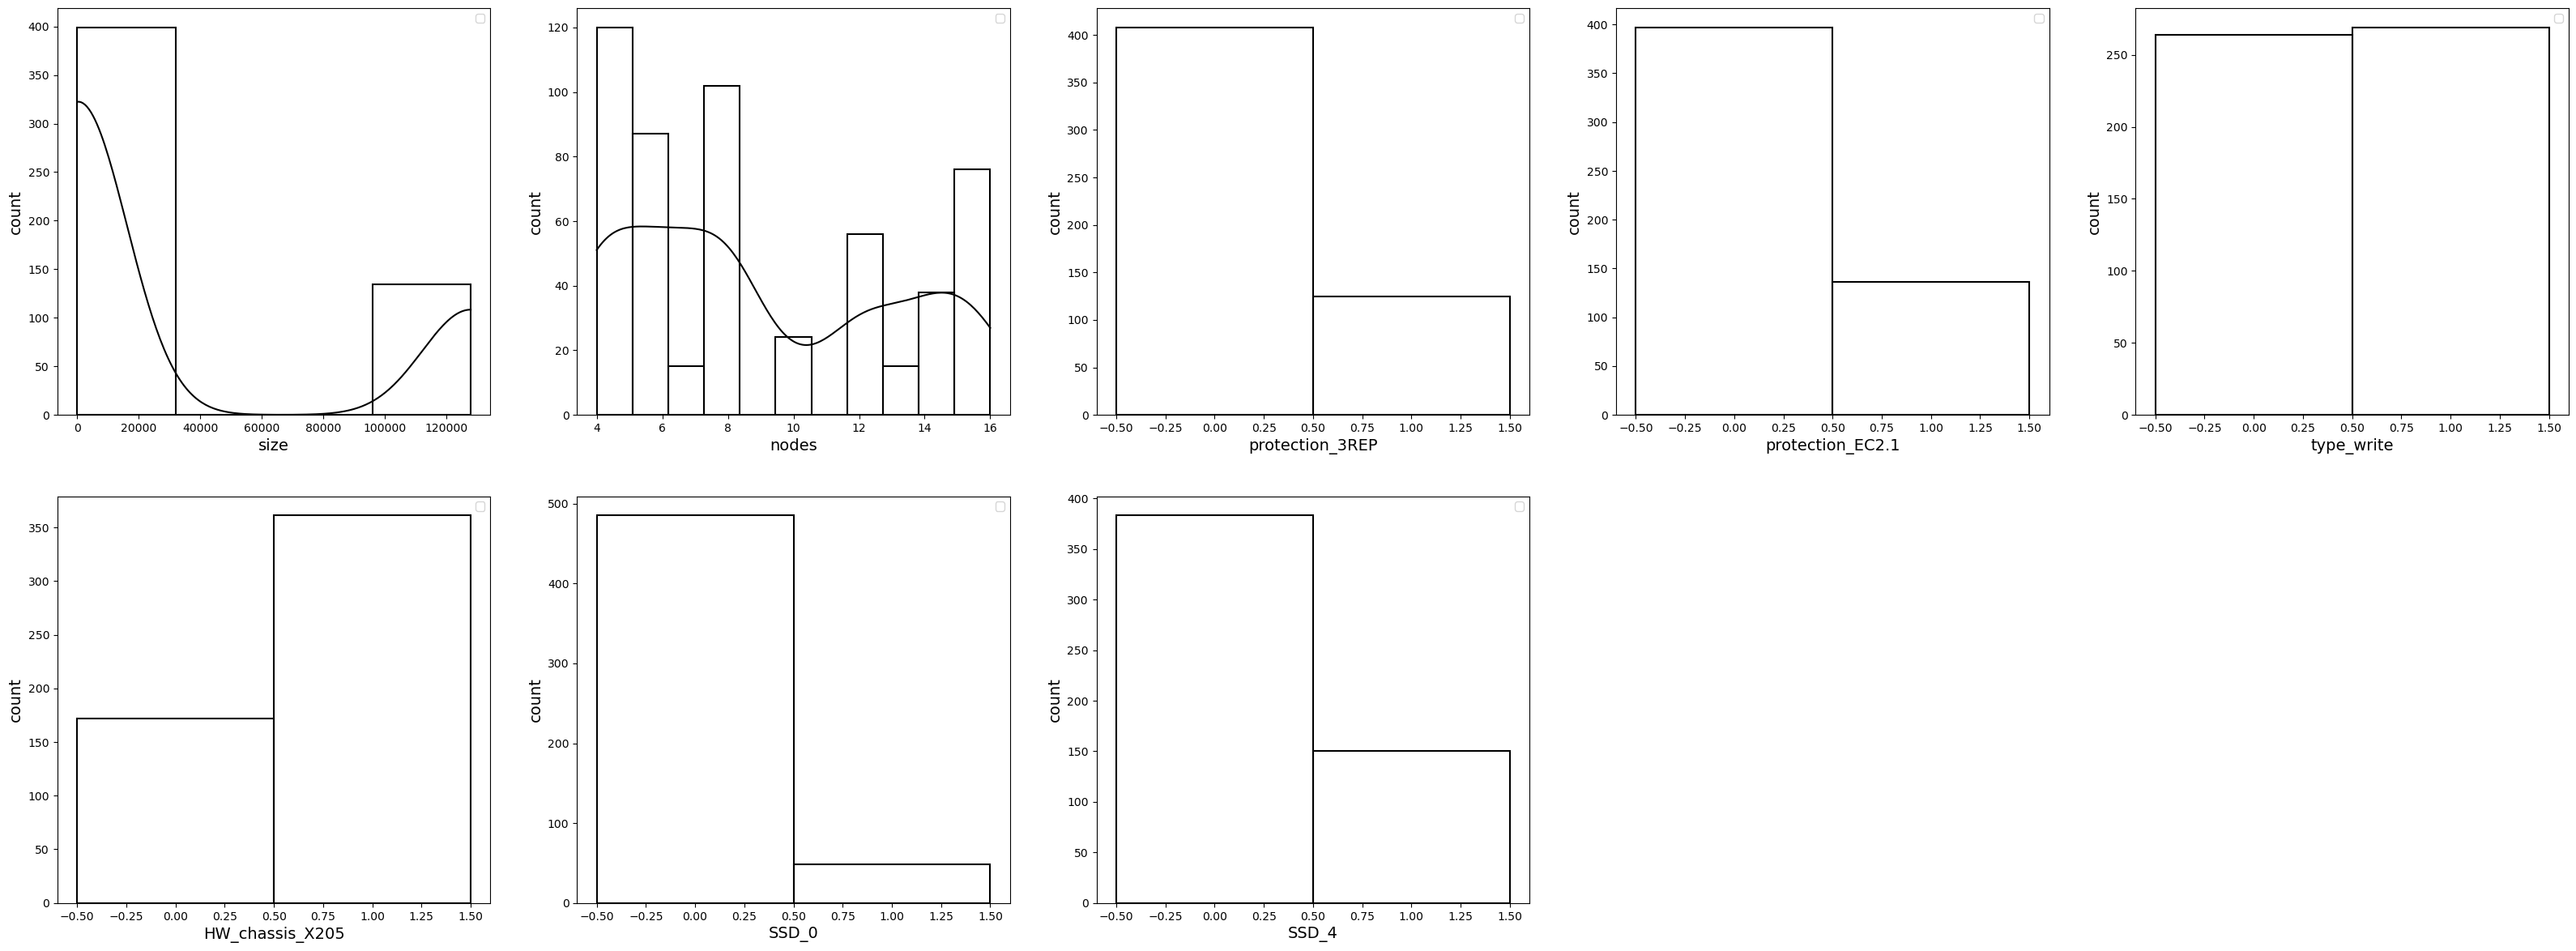

In [13]:
plt.figure(figsize=(40,30))
header_temp = list(df.columns)
header_temp.remove('SUM_op/s')
n = len(header_temp)

for i in range(n):
    plt.subplot(n // 2, n - n // 2 + 1,i + 1)
    #X = list(df[header_temp[i]] if (header_temp[i] != 'size') else df[header_temp[i]].apply(lambda x: np.log(x)))
    X = list(df[header_temp[i]])
    Y = list(df['SUM_op/s'])
    n_bins = len(list(df[header_temp[i]].unique()))
    cont_switch = True if (header_temp[i] in cont_params) else False 
    his = sns.histplot(X, bins=n_bins, color='k', kde=cont_switch, fill=False, discrete=(not cont_switch))
    plt.title('', fontsize=15)
    plt.xlabel(header_temp[i], fontsize=14, color='k')
    plt.ylabel('count', fontsize=14, color='k')
    plt.legend()
plt.show()
sns.reset_orig()

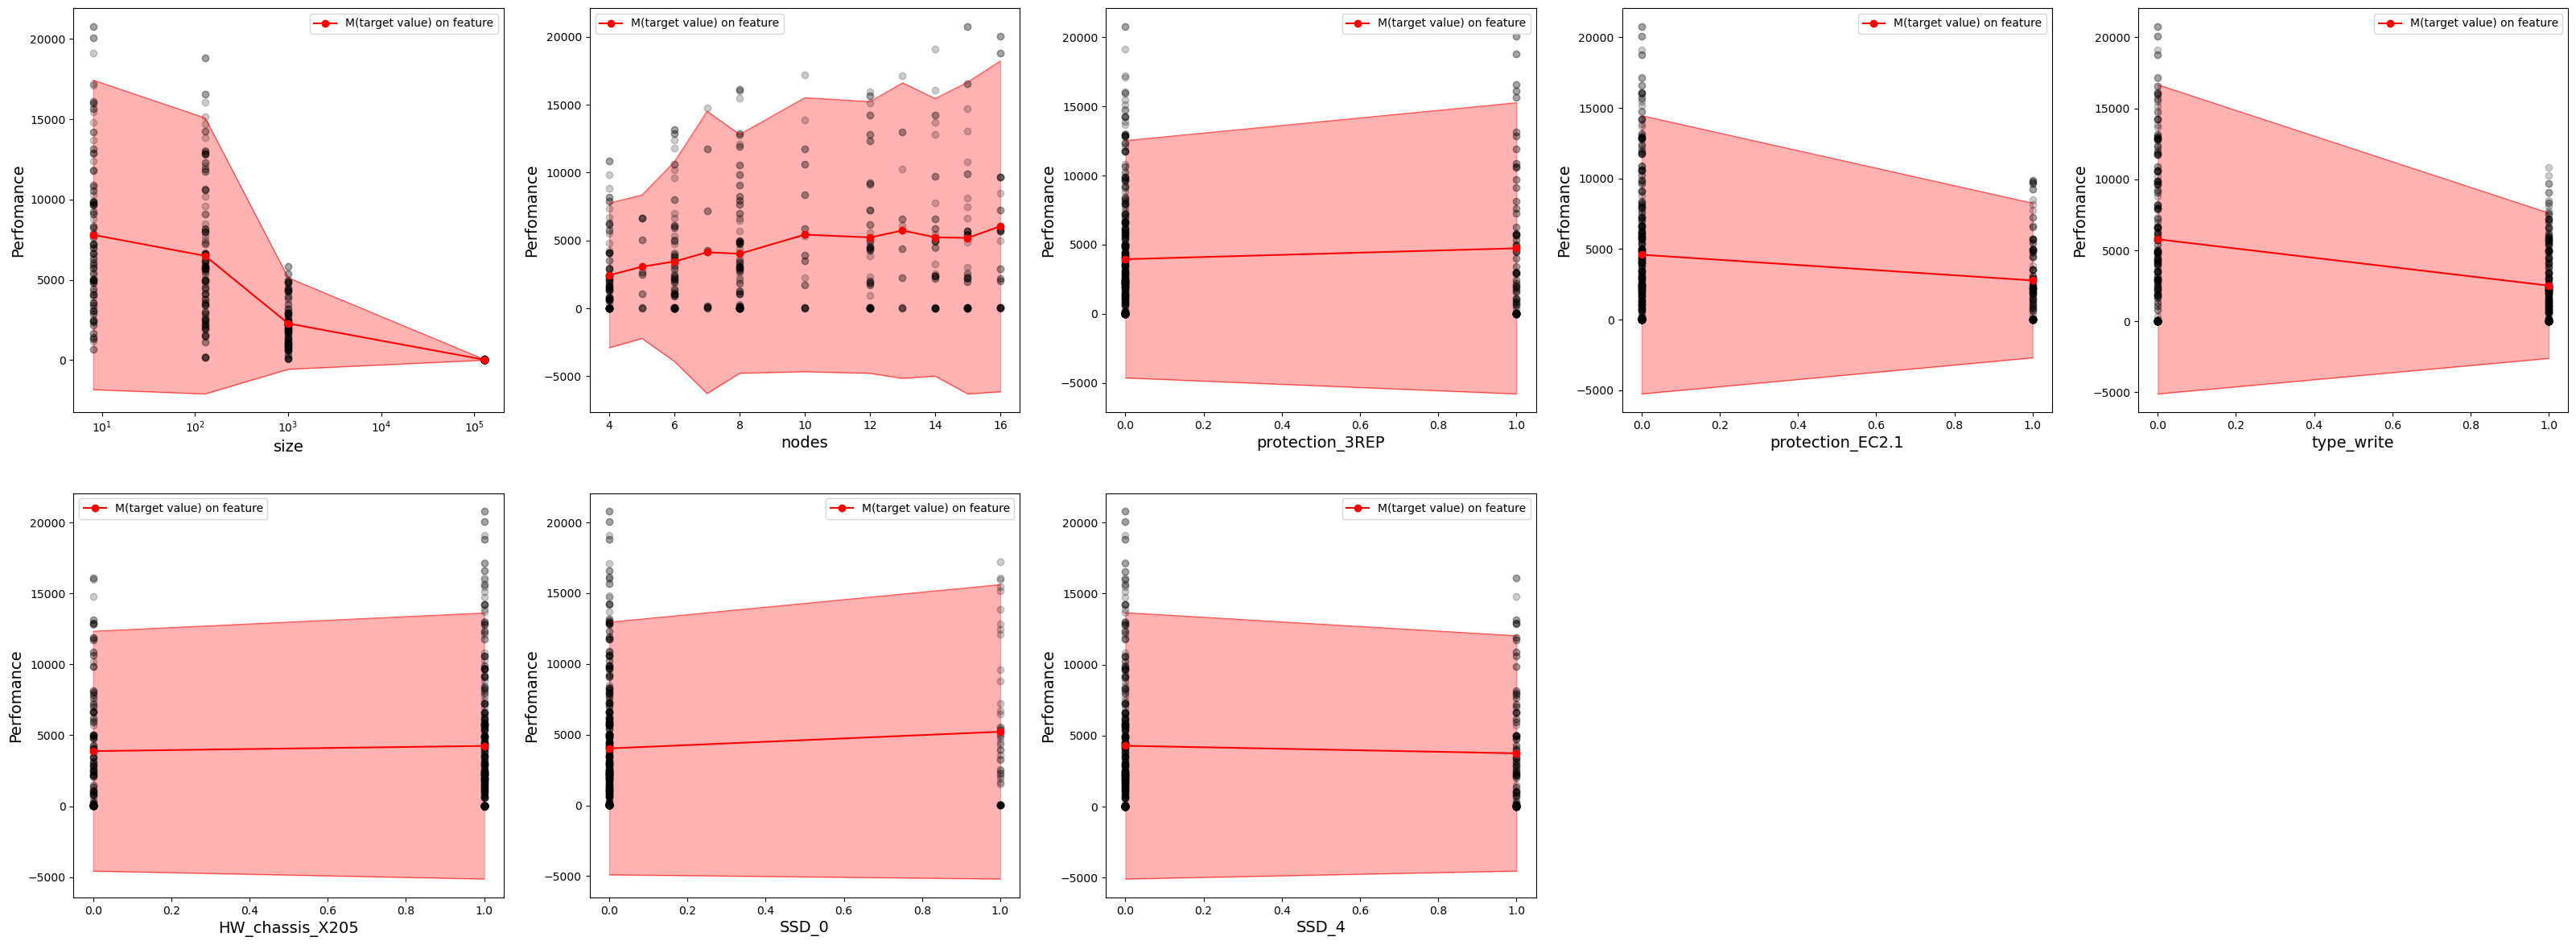

In [14]:
plt.figure(figsize=(40,30))
header_temp = list(df.columns)
header_temp.remove('SUM_op/s')
n = len(header_temp)
for i in range(n):
    plt.subplot(n // 2, n - n // 2 + 1,i + 1)
    if header_temp[i] == 'size':
        plt.xscale('symlog')
    else:
        plt.xscale('linear')
    X = list(df[header_temp[i]])
    Y = list(df['SUM_op/s'])
    mean_values = df.groupby(header_temp[i])['SUM_op/s'].mean().reset_index()
    mean_values.columns = ['X', 'Mean_Y']
    var_values = df.groupby(header_temp[i])['SUM_op/s'].var().reset_index()
    var_values.columns = ['X', 'Var_Y']
    plt.plot(mean_values['X'], mean_values['Mean_Y'], color='red', marker='o', label='M(target value) on feature')
    plt.plot(var_values['X'], mean_values['Mean_Y'] + 2 * np.sqrt(var_values['Var_Y']), color='red', alpha = 0.6, linewidth = 0.7)
    plt.plot(var_values['X'], mean_values['Mean_Y'] - 2 * np.sqrt(var_values['Var_Y']), color='red', alpha = 0.6, linewidth = 0.7)
    plt.fill_between(
        var_values['X'], mean_values['Mean_Y'] - 2 * np.sqrt(var_values['Var_Y']), 
        mean_values['Mean_Y'] + 2 * np.sqrt(var_values['Var_Y']), 
        where=(
            mean_values['Mean_Y'] + 2 * np.sqrt(var_values['Var_Y']) > mean_values['Mean_Y'] - 2 * np.sqrt(var_values['Var_Y'])
            ), color='red', alpha=0.3
            )
    plt.scatter(X, Y, color='black', marker='o', alpha=0.2)
    plt.title('', fontsize=15)
    plt.xlabel(header_temp[i], fontsize=14, color='k')
    plt.ylabel('Perfomance', fontsize=14, color='k')
    plt.legend()
plt.show()

#### Missed features
смотрим, где нет значений

C:\Users\shiri\AppData\Local\Temp\ipykernel_7564\3808221701.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)


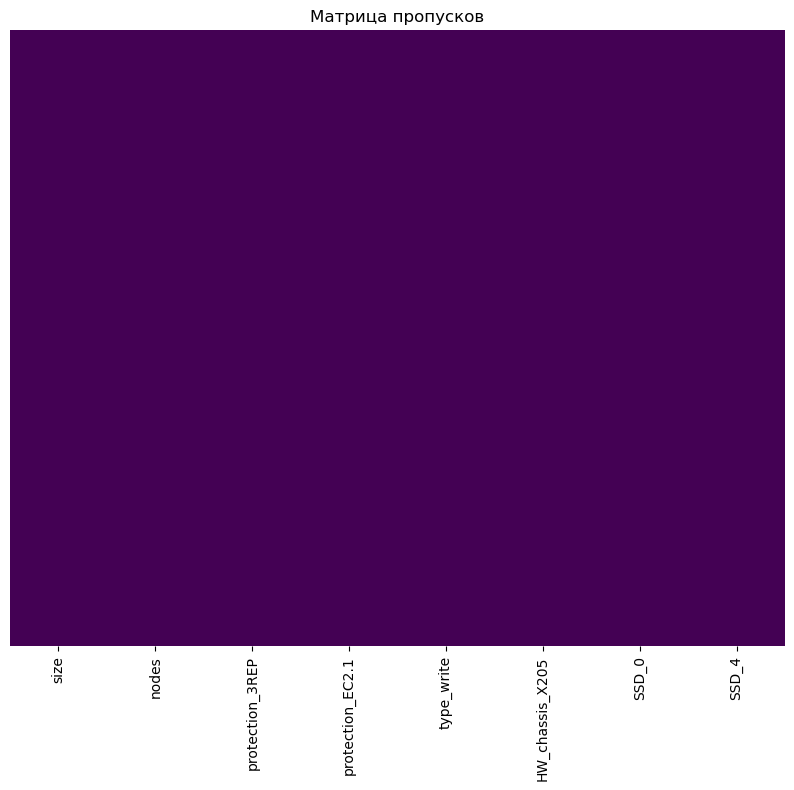

In [15]:
df_features = features_transformation(Data).drop('SUM_op/s', axis=1)
plt.figure(figsize=(10, 8))
missed = sns.heatmap(df_features.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Матрица пропусков')
plt.show()
sns.reset_orig()


#### Correlation matrix

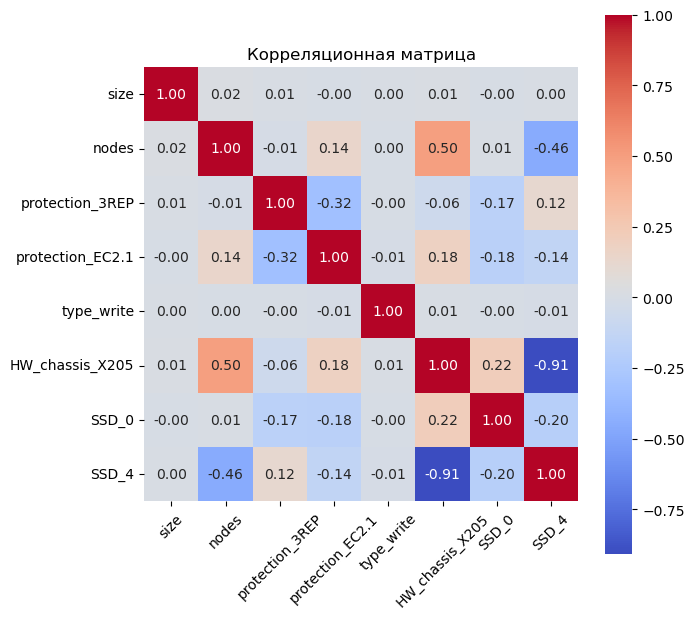

In [16]:
correlation_matrix = df_features.corr()
plt.figure(figsize=(7, 7))
hmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
hmap.set_xticklabels(hmap.get_xmajorticklabels(), rotation=45)
plt.title('Корреляционная матрица')
plt.show()
sns.reset_orig()


**Вывод из матрицы корреляции**  
*Будем считать, что два признака кореллированы, если их коэффициент корреляции по модулю превосходит $0.7$.*  
Видно, что признаки `SSD` и `HW_chassis_X205` линейно зависимы, это объясняется тем, что замеры на `HW_chassis` = "X205" проводились при `SSD` = 2, а, замеры на `HW_chassis` = "VEGMAN" проводились при `SSD` = 4.  
Зависимость не значима.

### Raw data preprocessing

#### Validation of raw data

##### Founder

Скрипт автоматически ищет ключи с несоответственным поведением таргет валью от изменений непрерывных параметров исходя из бизнес-логики.
Один проход скрипта, очевидно, не отыщет все корявые замеры - нужно итеративно проходиться, удаляя по пути найденые ошибки.

In [17]:
def founder(Data):
    '''
    Функция реально зависит только от Даты: именно состояние замеров в репе является ключевым объектом работы скрипта
    '''
    Broken_sizes = []  # [ {"protection": , "size": , "nodes": , "type": , "hw_chassis": , "number_of_ssd": , "nodes": } ]

    for index, parametr in itertools.product(range(max_index + 1), cont_params):

        doc_wout_param = doc.copy()

        doc_wout_param.pop(parametr)

        cross_doc = list(itertools.product(*list(doc_wout_param.values())))

        n = key_enum(parametr)
        cross_doc = [cross_doc[i][:n] + tuple([0]) + cross_doc[i][n:] for i in range(len(cross_doc))]

        cross_doc_dict = [
            {
                list(doc.keys())[i]: item[i] for i in range(len(list(doc.keys())))
            } for item in cross_doc

        ]  # костыльно добавляем нуль в валью парама, чтобы не изменять функцию compare

        for i in range(len(cross_doc_dict)):

            X = [
                key[1][key_enum(parametr)] for key in list(Data.keys()) if (compare(key[1], parametr, cross_doc_dict[i]) and key[0] == index)
                ]
            
            Y = [
                    Data[(index, key[1])]['SUM_op/s'] for key in list(Data.keys()) if (compare(key[1], parametr, cross_doc_dict[i]) and key[0] == index)
                ] if len(X) != 0 else []

            W = np.array((X, Y)).T   # (cont., target value)

            if parametr == "nodes":
                W = W[W[:, 0].argsort()].T
            elif parametr == "size":
                W = W[W[:, 0].argsort()[::-1]].T  # ревёрсим массив для сайза, по БЛ при увеличении сайза, уменьшается таргеты

            for j in range(len(W[0]) - 1):
                if W[1][j] > W[1][j+1]:
                    if parametr == "nodes":
                        Broken_sizes.append(
                            (index ,{
                                "protection": cross_doc_dict[i]["protection"],
                                "size": cross_doc_dict[i]["size"],
                                "nodes": W[0][j+1],
                                "type": cross_doc_dict[i]["type"],
                                "HW_chassis": cross_doc_dict[i]["HW_chassis"],
                                "SSD": cross_doc_dict[i]["SSD"]
                            })
                        )
                    else:
                        Broken_sizes.append(
                            (index, {
                                "protection": cross_doc_dict[i]["protection"],
                                "size": W[0][j+1],
                                "nodes": cross_doc_dict[i]["nodes"],
                                "type": cross_doc_dict[i]["type"],
                                "HW_chassis": cross_doc_dict[i]["HW_chassis"],
                                "SSD": cross_doc_dict[i]["SSD"]
                            })
                        )

    return {"len": len(Broken_sizes), "broken_sizes": Broken_sizes}





##### Auto purifier
Скрипт удаляет все некорректные замеры.

In [19]:
def auto_cleaner(Data: dict) -> dict:
    Data_operated = Data.copy()
    removed_data = {}
    while founder(Data_operated)["len"] > 0:
        for item in founder(Data_operated)["broken_sizes"]:
            index = item[0]
            item = item[1]
            temp = Data_operated.pop((index, tuple(item.values())), None)
            if temp is not None:
                removed_data[(index, tuple(item.values()))] = temp["SUM_MB/s"]
    return {"data": Data_operated, "removed_data": removed_data}


Очистим нашу дату от ошибочных замеров

In [20]:
cleaned_data_temp = auto_cleaner(Data)  # вычислительно затратная функция, предпосчитаем её

In [29]:
df_cleaned = features_transformation(cleaned_data_temp["data"])

print(df_cleaned, '\n', f'removed {len(cleaned_data_temp["removed_data"])} points of data')


         size  nodes      SUM_op/s  protection_3REP  protection_EC2.1  \
0         8.0     16   9680.554701                1                 0   
1         8.0     16  20065.334488                1                 0   
2       128.0     16   5681.330100                1                 0   
3       128.0     16  18788.737276                1                 0   
4      1000.0     16   2042.689679                1                 0   
..        ...    ...           ...              ...               ...   
473     128.0      4   1936.546119                0                 1   
474    1000.0      4    646.974487                0                 1   
475    1000.0      4    797.192718                0                 1   
476  128000.0      4      7.994045                0                 1   
477  128000.0      4     11.903917                0                 1   

     type_write  HW_chassis_X205  SSD_0  SSD_4  
0             1                1      0      0  
1             0          

C:\Users\shiri\AppData\Local\Temp\ipykernel_7564\3808221701.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)


можем записать в .xlsx то, что удалили

In [26]:
header_cleaned_to_out = list(doc.keys()) + ["SUM_MB/s"]
list_cleaned_to_out = [
    list(key[1]) + [cleaned_data_temp["removed_data"][key]] for key in list(cleaned_data_temp["removed_data"].keys())
]
df_cleaned_to_out = pd.DataFrame(list_cleaned_to_out, columns=header_cleaned_to_out)
df_cleaned_to_out.to_excel('output.xlsx', index=False, header=True)
print(df_cleaned_to_out)

   protection   size  nodes   type HW_chassis  SSD  SUM_MB/s
0        2REP    8.0    4.0  write       X205    0      29.0
1        2REP    8.0    4.0  write       X205    2      10.7
2        2REP    8.0    4.0   read       X205    2      33.0
3        2REP    8.0    6.0  write       X205    2      17.8
4        2REP    8.0    8.0  write       X205    2      28.0
5        2REP    8.0    8.0   read     VEGMAN    4      81.0
6        2REP    8.0   10.0  write       X205    0      32.0
7        2REP    8.0   14.0  write       X205    0      27.0
8        2REP    8.0   14.0  write       X205    2      20.0
9        2REP    8.0   14.0   read       X205    0     105.0
10      EC2.1    8.0    4.0  write       X205    2      11.8
11      EC2.1    8.0    4.0   read       X205    2      13.6
12      EC2.1    8.0    8.0  write       X205    2      26.0
13      EC2.1    8.0   12.0  write       X205    2      36.0
14      EC2.1    8.0   14.0  write       X205    2      41.0
15      EC2.1    8.0   1

#### Scaling

In [30]:
min_max_scaler = MinMaxScaler()
df_scaled = df_cleaned
target_value = df_scaled.pop("SUM_op/s")
df_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_scaled), columns=df_scaled.columns)
df_scaled = pd.concat([df_scaled, target_value], axis=1)
print(df_scaled)


         size  nodes  protection_3REP  protection_EC2.1  type_write  \
0    0.000000    1.0              1.0               0.0         1.0   
1    0.000000    1.0              1.0               0.0         0.0   
2    0.000938    1.0              1.0               0.0         1.0   
3    0.000938    1.0              1.0               0.0         0.0   
4    0.007750    1.0              1.0               0.0         1.0   
..        ...    ...              ...               ...         ...   
473  0.000938    0.0              0.0               1.0         0.0   
474  0.007750    0.0              0.0               1.0         1.0   
475  0.007750    0.0              0.0               1.0         0.0   
476  1.000000    0.0              0.0               1.0         1.0   
477  1.000000    0.0              0.0               1.0         0.0   

     HW_chassis_X205  SSD_0  SSD_4      SUM_op/s  
0                1.0    0.0    0.0   9680.554701  
1                1.0    0.0    0.0  20065.334

#### Define weights
Проверим, какие фифчи влияют на таргет валью

In [31]:
M = LinearRegression()
header_temp_lr = list(df_scaled.loc[:, df_scaled.columns != 'SUM_op/s'].columns) + ['intercept']
x_lr = np.array(df_scaled.loc[:, df_scaled.columns != 'SUM_op/s'])
y_lr = np.array(df_scaled['SUM_op/s'])
M.fit(x_lr, y_lr)
weights = np.append(M.coef_, M.intercept_)
df_weights = pd.DataFrame(np.array(weights)).T
df_weights.columns = header_temp_lr
print(df_weights)


          size        nodes  protection_3REP  protection_EC2.1   type_write  \
0 -5647.056479  4319.926117       265.719207      -2017.974043 -3045.536799   

   HW_chassis_X205       SSD_0       SSD_4   intercept  
0     -1356.987921  828.932194 -439.729106  6804.88737  


#### Visualization results after post processing

C:\Users\shiri\AppData\Local\Temp\ipykernel_19436\4286328807.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shiri\AppData\Local\Temp\ipykernel_19436\4286328807.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shiri\AppData\Local\Temp\ipykernel_19436\4286328807.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shiri\AppData\Local\Temp\ipykernel_19436\4286328807.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  p

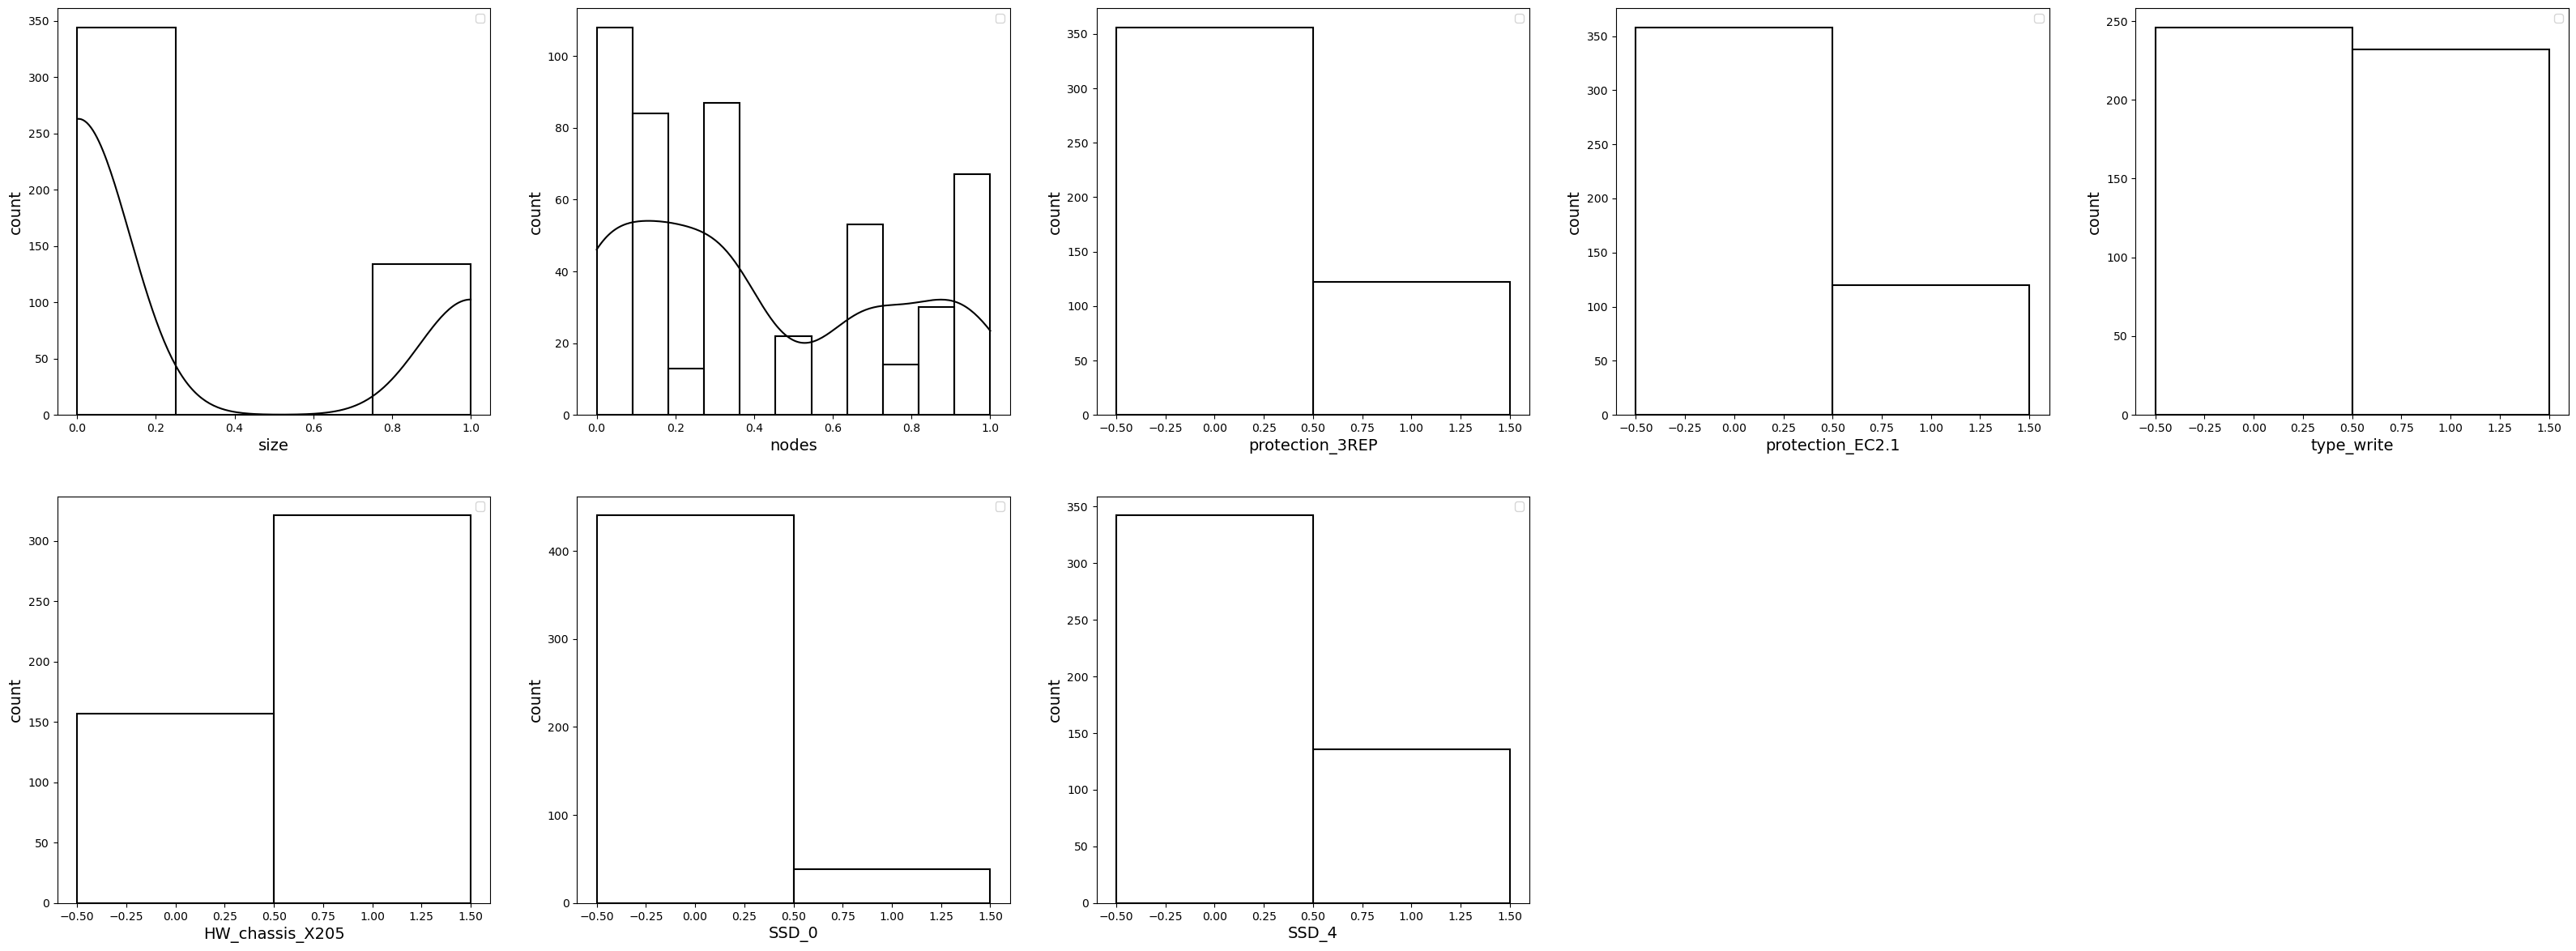

In [ ]:
plt.figure(figsize=(40,30))
header_temp = list(df.columns)
header_temp.remove('SUM_op/s')
n = len(header_temp)

for i in range(n):
    plt.subplot(n // 2, n - n // 2 + 1,i + 1)
    #X = list(df_scaled[header_temp[i]] if (header_temp[i] != 'size') else df_scaled[header_temp[i]].apply(lambda x: np.log(x+1)))
    X = list(df_scaled[header_temp[i]])
    Y = list(df_scaled['SUM_op/s'])
    n_bins = len(list(df_scaled[header_temp[i]].unique()))
    cont_switch = True if ((header_temp[i] in cont_params)) else False 
    his = sns.histplot(X, bins=n_bins, color='k', kde=cont_switch, fill=False, discrete=(not cont_switch))
    plt.title('', fontsize=15)
    plt.xlabel(header_temp[i], fontsize=14, color='k')
    plt.ylabel('count', fontsize=14, color='k')
    plt.legend()
plt.show()
sns.reset_orig()

смотрим на матрицу корреляции после валидации даты

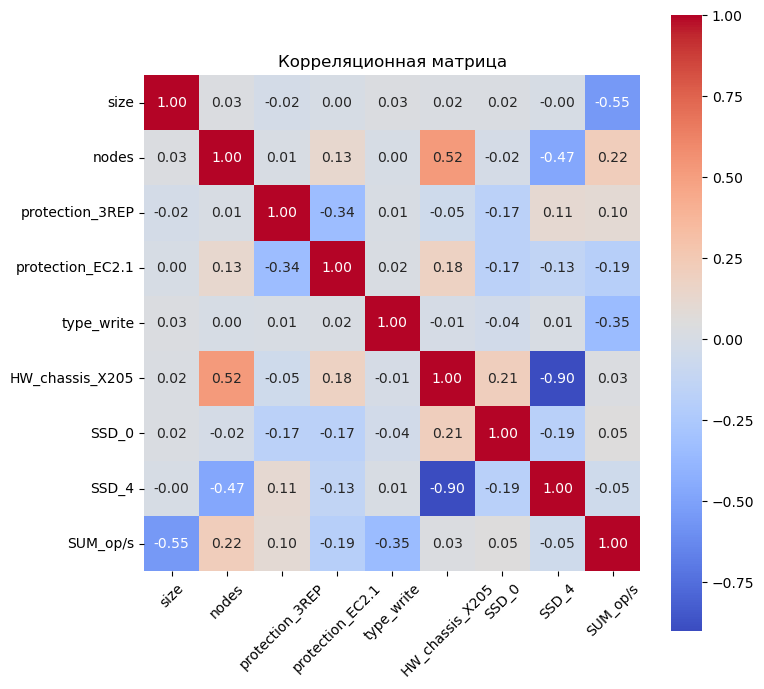

In [ ]:
df_temp = df_scaled.copy()
df_temp.drop('SUM_op/s', axis=1)
correlation_matrix = df_temp.corr()
plt.figure(figsize=(8, 8))
hmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
hmap.set_xticklabels(hmap.get_xmajorticklabels(), rotation=45)
plt.title('Корреляционная матрица')
plt.show()
sns.reset_orig()


видим, что корр в среднем уменьшился

#### Visualization

In [ ]:
parametr = 'size'
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''

### fix other params for detail searching (order as in documentation dictionary - it`s important)
fix_params = {
    'protection': '3REP',
    'size': 8,
    'nodes': 4,
    'type': 'write',
    'HW_chassis': 'X205',
    'SSD': 2
}
### we can define here other pack of params for compare
fix_params_2 = {
    'protection': '3REP',
    'size': 8,
    'nodes': 8,
    'type': 'write',
    'HW_chassis': 'VEGMAN',
    'SSD': 4
}
###

params:
           first graph second graph
protection        3REP         3REP
nodes                4            8
type             write        write
HW_chassis        X205       VEGMAN
SSD                  2            4


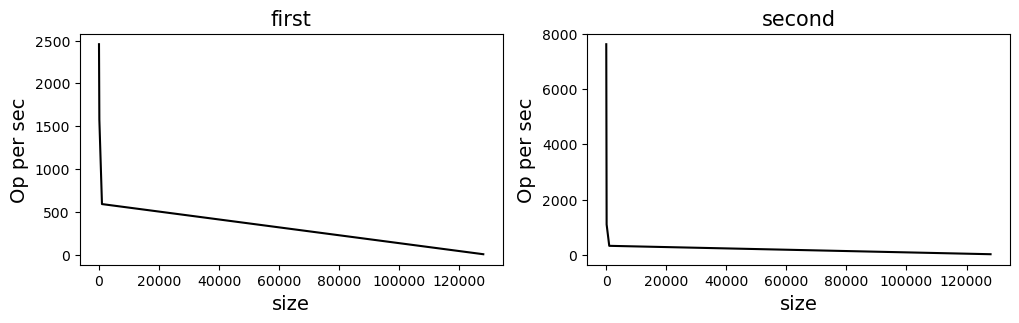

additional info: index_1 = 0, index_2 = 0


In [ ]:
indeces = Counter([key[1] for key in list(Data.keys())])

# рандомим индекс партии, чтобы не заморачиваться - всем индексам соответствует какая - то партия замеров (обеспечено Counter'ом), но партия мб из 1 точки
index_1 = random.choice(range(indeces[tuple(fix_params.values())]))
index_2 = random.choice(range(indeces[tuple(fix_params_2.values())]))
index_1 = 0; index_2 = 0  # надёжный вариант, комментим строку, если хотим рандома

Z = np.array((
    [
        key[1][key_enum(parametr)] for key in list(Data.keys()) if (compare(key[1], parametr, fix_params) and key[0] == index_1)
    ],
    [
        Data[key]['SUM_op/s'] for key in list(Data.keys()) if (compare(key[1], parametr, fix_params) and key[0] == index_1)
    ]
)).T

W = np.array((
    [
        key[1][key_enum(parametr)] for key in list(Data.keys()) if (compare(key[1], parametr, fix_params_2) and key[0] == index_2)
    ],
    [
        Data[key]['SUM_op/s'] for key in list(Data.keys()) if (compare(key[1], parametr, fix_params_2) and key[0] == index_2)
    ]
)).T

plt.figure(figsize=(12, 3)) 

plt.subplot(1, 2, 1)
plt.xscale('linear')

Z = Z[Z[:, 0].argsort()].T; W = W[W[:, 0].argsort()].T

graph_title = {key: {'first graph': fix_params[key], 'second graph': fix_params_2[key]} for key in list(doc.keys())}

plt.plot(Z[0], Z[1],'k-', alpha = 1)
graph_title.pop(parametr, None)
print(f'params:\n{pd.DataFrame(graph_title).transpose()}')
plt.title('first', fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')


plt.subplot(1, 2, 2)
plt.xscale('linear')
plt.plot(W[0], W[1],'k-', alpha = 1)
plt.title('second', fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')
plt.show()

print(f'additional info: index_1 = {index_1}, index_2 = {index_2}')


Из графиков выше, мы должны понять характер роста производительности

### Modelling

_about_: использованы байесовские методы из PyMC.

#### Data transformation

Линейная модель, PyMC $$predict = \boldsymbol{weights}\cdot \boldsymbol{features} + intercept \;\text{неактуально}$$

#### Model training

In [ ]:
X = np.concatenate(
        (
            np.array(df_scaled)[:, :3], np.array(df_scaled)[:, 4:]
        ), axis = 1) # predictor
Y = np.array(df_scaled["SUM_op/s"]) # target
print(f'shape of X {X.shape}, shape of Y {Y.shape}')


shape of X (478, 8), shape of Y (478,)


In [ ]:
def G(X: np.ndarray) -> np.ndarray:
    mu = (60) / (128e3 - 8)  # old mu = 68
    sigma = (465/2 - 8) / (128e3 - 8)  # old sigma = 465/2
    return np.exp( - (X - mu) ** 2 / sigma ** 2)

In [ ]:
# X: (N, M), Y: (N,)
# define features
size = np.array(df_scaled["size"])
nodes = np.array(df_scaled["nodes"])
protection_3REP = np.array(df_scaled["protection_3REP"])
protection_EC21 = np.array(df_scaled["protection_EC2.1"])
type_write = np.array(df_scaled["type_write"])
HW_chassis_X205 = np.array(df_scaled["HW_chassis_X205"])
SSD_0 = np.array(df_scaled["SSD_0"])
SSD_4 = np.array(df_scaled["SSD_4"])

# определение байесовской модели
with pm.Model() as model:
    # определение априорных распределений из бизнес логики
    slope_size = pm.Uniform("slope_size", lower=8, upper=128e3)
    slope_size_G = pm.Uniform("slope_size_G", lower=8, upper=128e3)
    slope_nodes = pm.Uniform("slope_nodes", lower=4, upper=100)
    slope_nodes_log = pm.Uniform("slope_nodes_log", lower=4, upper=100)
    slope_protection_3REP = pm.Bernoulli("slope_protection_3REP", p=1/3)
    slope_protection_EC21 = pm.Bernoulli("slope_protection_EC21", p=1/3)
    slope_type_write = pm.Bernoulli("slope_type_write", p=1/2)
    slope_HW_chassis_X205 = pm.Bernoulli("slope_HW_chassis_X205", p=1/2)
    slope_SSD_0 = pm.Bernoulli("slope_SSD_0", p=1/3)
    slope_SSD_4 = pm.Bernoulli("slope_SSD_4", p=1/3)
    intercept = pm.Normal("intercept", mu=0, sigma=100)

    sigma = pm.HalfNormal('sigma', sigma=1)
    
    y_obs = pm.Normal("y_obs", mu=(
                          (slope_size * size + slope_size_G * G(size)) *
                          (slope_nodes * nodes + 
                          slope_nodes_log * np.log(nodes + 1) +
                          slope_protection_3REP * protection_3REP + 
                          slope_protection_EC21 * protection_EC21 +
                          slope_type_write * type_write +
                          slope_HW_chassis_X205 * HW_chassis_X205 +
                          slope_SSD_0 * SSD_0 +
                          slope_SSD_4 * SSD_4) +
                          intercept
                      ), sigma=sigma, observed=Y)

    # Сэмплирование
    trace = pm.sample(100, tune=100)



Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [slope_size, slope_size_G, slope_nodes, slope_nodes_log, intercept, sigma]
>BinaryGibbsMetropolis: [slope_protection_3REP, slope_protection_EC21, slope_type_write, slope_HW_chassis_X205, slope_SSD_0, slope_SSD_4]


c:\Users\shiri\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 303 seconds.
c:\Users\shiri\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
print(trace.keys())

KeysView(Inference data with groups:
	> posterior
	> sample_stats
	> observed_data)


In [ ]:
az.summary(trace)

c:\Users\shiri\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope_protection_3REP,1.000,0.000,1.000,1.000,0.000,0.000,200.0,200.0,NaN
slope_protection_EC21,0.000,0.000,0.000,0.000,0.000,0.000,200.0,200.0,NaN
slope_type_write,0.000,0.000,0.000,0.000,0.000,0.000,200.0,200.0,NaN
slope_HW_chassis_X205,0.000,0.000,0.000,0.000,0.000,0.000,200.0,200.0,NaN
slope_SSD_0,1.000,0.000,1.000,1.000,0.000,0.000,200.0,200.0,NaN
slope_SSD_4,1.000,0.000,1.000,1.000,0.000,0.000,200.0,200.0,NaN
intercept,80.191,55.452,-0.044,173.662,34.641,27.995,3.0,12.0,2.38
slope_size,14.820,11.739,8.007,29.591,4.573,3.388,4.0,27.0,1.54
slope_size_G,3358.954,22.452,3326.540,3397.525,11.597,8.973,3.0,20.0,1.72
slope_nodes,4.004,0.021,4.000,4.005,0.003,0.002,9.0,12.0,1.17


In [ ]:
# Извлечение параметров из trace
slope_size_samples = trace.posterior['slope_size'].values.flatten()
slope_size_G_samples = trace.posterior['slope_size_G'].values.flatten()
slope_nodes_samples = trace.posterior['slope_nodes'].values.flatten()
slope_nodes_log_samples = trace.posterior['slope_nodes_log'].values.flatten()
slope_protection_3REP_samples = trace.posterior['slope_protection_3REP'].values.flatten()
slope_protection_EC21_samples = trace.posterior['slope_protection_EC21'].values.flatten()
slope_type_write_samples = trace.posterior['slope_type_write'].values.flatten()
slope_HW_chassis_X205_samples = trace.posterior['slope_HW_chassis_X205'].values.flatten()
slope_SSD_0_samples = trace.posterior['slope_SSD_0'].values.flatten()
slope_SSD_4_samples = trace.posterior['slope_SSD_4'].values.flatten()
intercept_samples = trace.posterior['intercept'].values.flatten()


In [ ]:
parametr = 'nodes'
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''

### fix other params for detail searching (order as in documentation dictionary - it`s important)
fix_params = {
    'protection': '2REP',
    'size': 128_000,
    'nodes': 15,
    'type': 'read',
    'HW_chassis': 'X205',
    'SSD': 2
}


params:
           first graph
protection        2REP
size            128000
type              read
HW_chassis        X205
SSD                  2


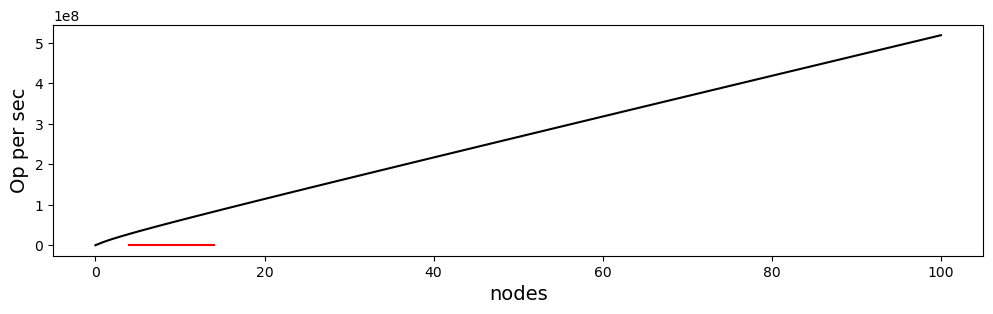

In [ ]:
index_pr = 0
Z = np.array((
    [
        key[1][key_enum(parametr)] for key in list(Data.keys()) if (compare(key[1], parametr, fix_params) and key[0] == index_pr)
    ],
    [
        Data[key]['SUM_op/s'] for key in list(Data.keys()) if (compare(key[1], parametr, fix_params) and key[0] == index_pr)
    ]
)).T

# Построение предсказаний
x_range_size = np.linspace(8, 128e3, int(127993 * 10e-3))
x_range_nodes = np.linspace(0, 100, 100)
x_range_SSD = np.linspace(2, 4, 2)
x_range_protection_3REP = np.linspace(0, 1, 2)
x_range_protection_EC21 = np.linspace(0, 1, 2)
x_range_type_write = np.linspace(0, 1, 2)
x_range_HW_chassis_X205 = np.linspace(0, 1, 2)
X_range = np.array(np.meshgrid(
    x_range_nodes
    )).T.reshape(-1, 1)

Z = Z[Z[:, 0].argsort()].T

y_pred_t = (
    (np.mean(slope_size_samples) * fix_params["size"] + np.mean(slope_size_G_samples) * G(fix_params["size"])) *( 
    np.mean(slope_nodes_samples) * X_range + np.mean(slope_nodes_log_samples) * np.log(X_range + 1) + 
    np.mean(slope_protection_3REP_samples) * 0 + 
    np.mean(slope_protection_EC21_samples) * 0 +
    np.mean(slope_type_write_samples) * 0 +
    np.mean(slope_HW_chassis_X205_samples) * 1 +
    np.mean(slope_SSD_0_samples) * 0 +
    np.mean(slope_SSD_4_samples) * 0) +
    np.mean(intercept_samples)
)

plt.figure(figsize=(12, 3)) 

plt.xscale('linear')

graph_title = {key: {'first graph': fix_params[key]} for key in list(doc.keys())}
plt.plot(Z[:, 0], Z[:, 1],'r-', alpha = 1)

plt.plot(X_range, y_pred_t,'k-', alpha = 1)
graph_title.pop(parametr, None)
print(f'params:\n{pd.DataFrame(graph_title).transpose()}')
plt.title('', fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')
plt.show()


In [ ]:
Y_predicted = (
    (np.mean(slope_size_samples) * np.array(df_scaled["size"]) + np.mean(slope_size_G_samples) * G(df_scaled["size"]))*( 
    np.mean(slope_nodes_samples) * np.array(df_scaled["nodes"]) + np.mean(slope_nodes_log_samples) * np.log(np.array(df_scaled["nodes"]) + 1) +
    np.mean(slope_protection_3REP_samples) * np.array(df_scaled["protection_3REP"]) + 
    np.mean(slope_protection_EC21_samples) * np.array(df_scaled["protection_EC2.1"]) +
    np.mean(slope_type_write_samples) * np.array(df_scaled["type_write"]) +
    np.mean(slope_HW_chassis_X205_samples) * np.array(df_scaled["HW_chassis_X205"]) +
    np.mean(slope_SSD_0_samples) * np.array(df_scaled["SSD_0"]) +
    np.mean(slope_SSD_4_samples) * np.array(df_scaled["SSD_4"])) +
    np.mean(intercept_samples)
)
r_squared = 1 - (np.sum((Y - Y_predicted) ** 2) / np.sum((Y - np.mean(Y)) ** 2))
print(f'R²: {r_squared}')

rmse = np.sqrt(np.sum((Y_predicted-Y) ** 2) / len(Y))

print(f'RMSE: {rmse}')


R²: 0.5272237924147227
RMSE: 3180.365583380264


## Summaries

## TODO

* посмотреть на разброс прогноза в интересующих нас точках и на зависимость этого разброса от модели и априорных распределений
    * построить интервалы для предсказаний в далеких точках и увидеть, что они слишком широкие
* рассмотреть несколько моделей
* провалидировать имеющиеся модели
* ошибки моделируются с помощью нормального распределения - пересмотреть эту позицию, предлагается: t - Стьюдент с 5 степенями свобод
* mu = (a * x[:, 0] + b * x[:,1]) * (c * x[:,2] + d) - изменить тип модели